# 2024 Winter Introduction to Deep Learning
### Based on Prof. Oh's Youtube Lecture
https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M

> Assignment #6


*   Youtube Lecture #23-26
*   Written by Seungeun Lee

## 3. Image Classification w/ pre-trained ResNet model -- custom dataset
*     Custom dataset: https://www.kaggle.com/datasets/jiweiliu/hymenoptera-data
*     Download the dataset and unzip it as always.



*    Reference. https://github.com/Justin-A/DeepLearning101/blob/master/4-6_Transfer_Learning.ipynb

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
%cd /content/drive/MyDrive/intro-dl/hymenoptera

/content/drive/MyDrive/intro-dl/hymenoptera


In [71]:
!unzip archive.zip

unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [72]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [73]:
# 런타임 - 런타임 유형 변경 - T4 GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.3.1+cu121  Device: cuda


In [74]:
BATCH_SIZE = 32
EPOCHS = 30

In [75]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize((299, 299)),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {x: datasets.ImageFolder("/content/drive/MyDrive/intro-dl/hymenoptera/hymenoptera_data", data_transforms[x]) for x in ['train', 'val']} ## Change Here! (Your directory)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, shuffle = True) for x in ['train', 'val']}


In [76]:
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 299, 299]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [77]:
y_train

tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1])

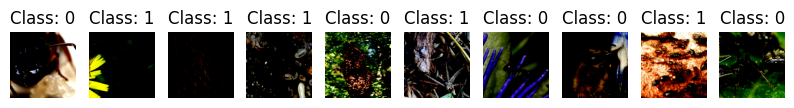

In [78]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [79]:
import torchvision.models as models
model = models.inception_v3(pretrained = True) # Load ResNet34 model w/ pre-trained weight. if False, then we only load the architeture of ResNet34, not the pre-trained weights.
print(model) # print the model architecture -- default ResNet34 model (pre-trained w/ Imagenet Dataset) has final 1000 output nodes
# BUT we have 2 classes in our custom dataset!!

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [80]:
## IMPORTANT: There are 2 ways to use pre-trained models

# (1) NOT updating the weights of the pre-trained models, and use the model as it is
for parameter in model.parameters():
    parameter.requires_grad = False # We previously learned the requires_grad means utilizing backpropagation

# (2) Updating the weights of the pre-trained mdoels
# for parameter in model.parameters():
#     parameter.requires_grad = True

# We usually use method #1 when using pre-trained models, but it's not the 100% perfect answer -- sometimes method #2 works better
# The optimal solution may vary according to the dataset or other techniques such as learning rate, optimizer, and so on

num_ftrs = model.fc.in_features # To mitigate the issues of the final layer, we should add one more layer having final 2 output nodes
model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1),
            nn.Sigmoid()
        ) # Add such layer!

model = model.to(DEVICE)

In [81]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
criterion = nn.BCELoss()

print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [82]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE, dtype=torch.float)
        label = label.to(DEVICE, dtype=torch.float)
        optimizer.zero_grad()
        output = model(image)

        if isinstance(output, tuple):
            output = output[0]
        # For inception

        output = output.squeeze(dim=1)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [83]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE, dtype=torch.float)
            label = label.to(DEVICE, dtype=torch.float)
            output = model(image)

            if isinstance(output, tuple):
                output = output[0]
            # For inception

            output = output.squeeze(dim=1)
            test_loss += criterion(output, label).item()
            output1 = output.cpu()
            output1[output1 >= 0.5] = 1
            output1[output1 < 0.5] = 0
            correct += output1.eq(label.cpu()).int().sum()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [84]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.691313
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.671191
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.646506

[EPOCH: 1], 	Test Loss: 0.6968, 	Test Accuracy: 61.46 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.654709
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.686480
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.633416

[EPOCH: 2], 	Test Loss: 0.6928, 	Test Accuracy: 61.96 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.586729
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.614785
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.665878

[EPOCH: 3], 	Test Loss: 0.6550, 	Test Accuracy: 64.48 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.610682
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.588435
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.666687

[EPOCH: 4], 	Test Loss: 0.6503, 	Test Accuracy: 64.23 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.670668
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.602997
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.728969

KeyboardInterrupt: 

### Question 1. Compare & Contrast the test result (accuracy) of requires_grad = False & True.


In [ ]:
# requires_grad = false
# Accuracy = 65.74%

# requires_grad = true
# Accuracy = 65.99%

# 큰 차이가 없었다

### Question 2. Change the model ResNet34 to ResNet50 and run the entire code. Compare & Contrast the results of those two models.


In [ ]:
# ResNet34
# Accuracy = 65.74%

# ResNet50
# Accuracy = 63.73%

# 큰 차이가 없었다

### Question 3. Change the model ResNet34 to Inceptionv3 or v4 and run the entire code. Compare & Contrast the results of those two models.

In [ ]:
# ResNet34
# Accuracy = 65.74%

# Inception_v3
# Accuracy = 67.00%

# 큰 차이가 없었다

### Question 4. Compare & Contrast the test result (accuracy) of pretrained=False & True. (models.resnet34(pretrained = True))

In [ ]:
# pretrained = false
# Accuracy = 62.72%

# pretrained = true
# Accuracy = 65.74%

# Pretrained가 false일 경우 도중에 정확도가 50%대까지
# 떨어지는 등 크게 불안정한 모습을 보였다

# 개미와 벌은 같은 곤충이라 구분하기 더 어려운 것으로 보인다
# 이후 Epoch이나 Learning rate 등을 조정해 보았으나 나아지지 않았다

### The End.

##### Please upload your Colab file @Github https://github.com/duneag2/intro-dl/tree/main/Assignment6

*   First, make your folder by your name (e.g. seungeun)
*   Then upload your "Jupyter Notebook" file under that directory

###### Need Help?



*   Please refer to this link https://yeko90.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-colab%EC%BD%94%EB%9E%A9%EC%97%90%EC%84%9C-%EC%95%95%EC%B6%95%ED%8C%8C%EC%9D%BC-%ED%92%80%EA%B8%B0 OR
*   Just save your Jupyter Notebook (.ipynb) file in here (colab) and upload via 'Add file' - 'Upload files' https://nthree.tistory.com/60